In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from prophet import Prophet

from sklearn.metrics import mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Rain Prediction/rainfall_dataset.csv")
df = df.set_index('date_time')
df.index = pd.to_datetime(df.index)

In [ ]:
df.head()

,rainfall
date_time,
2018-01-01 00:00:00,0.0
2018-01-01 03:00:00,0.0
2018-01-01 06:00:00,0.0
2018-01-01 09:00:00,0.0
2018-01-01 12:00:00,0.0


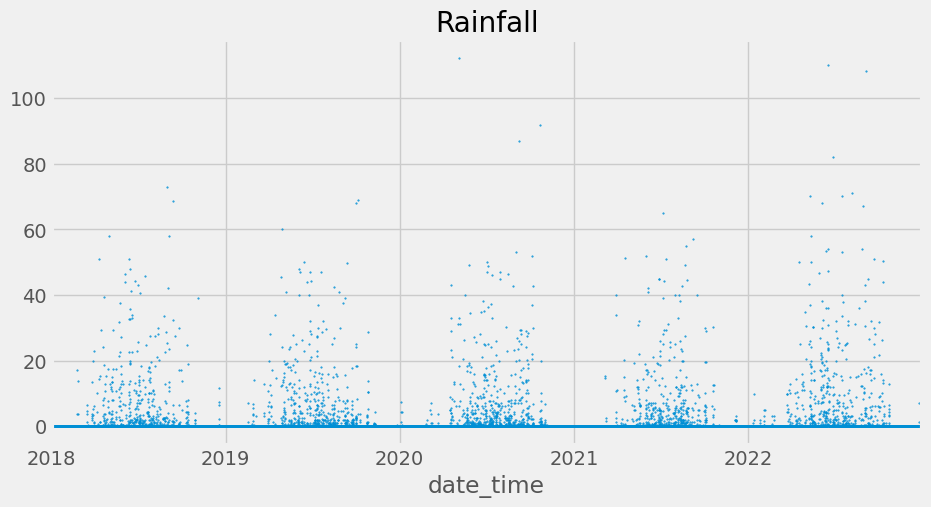

In [ ]:
color_pal = sns.color_palette()
df['rainfall'].plot(style='.',
          figsize=(10, 5),
          ms=1,
          color=color_pal[0],
          title='Rainfall')
plt.show()

# Time Series Features

In [ ]:
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday','Tuesday',
                                        'Wednesday',
                                        'Thursday','Friday',
                                        'Saturday','Sunday'],
                            ordered=True)

def create_features(df, label=None):
    """
    Creates time series features from datetime index.
    """
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    df['date_offset'] = (df.date.dt.month*100 + df.date.dt.day - 320)%1300

    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter']
                   )
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear','weekday',
           'season']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df, label='rainfall')
features_and_target = pd.concat([X, y], axis=1)

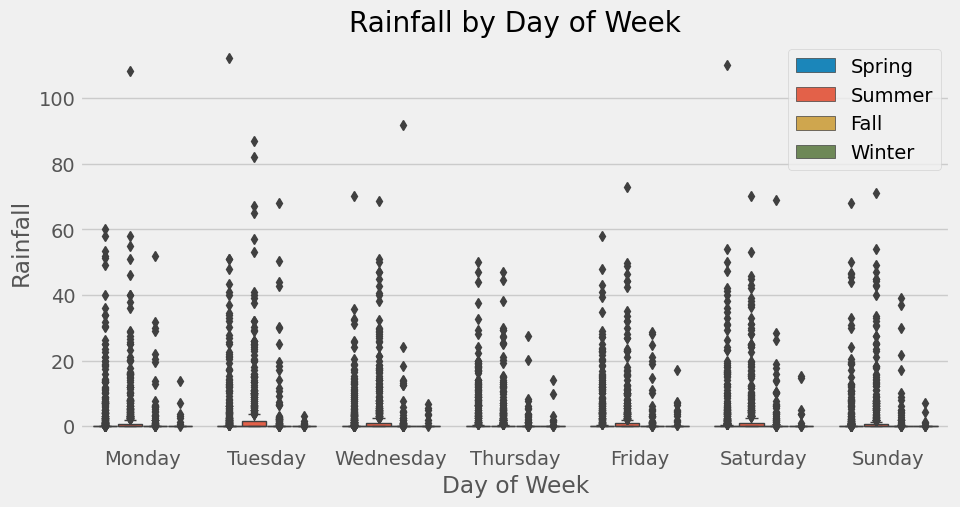

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.boxplot(data=features_and_target.dropna(),
            x='weekday',
            y='rainfall',
            hue='season',
            ax=ax,
            linewidth=1)
ax.set_title('Rainfall by Day of Week')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Rainfall')
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

# Train / Test Split

In [ ]:
df = df[['rainfall']]

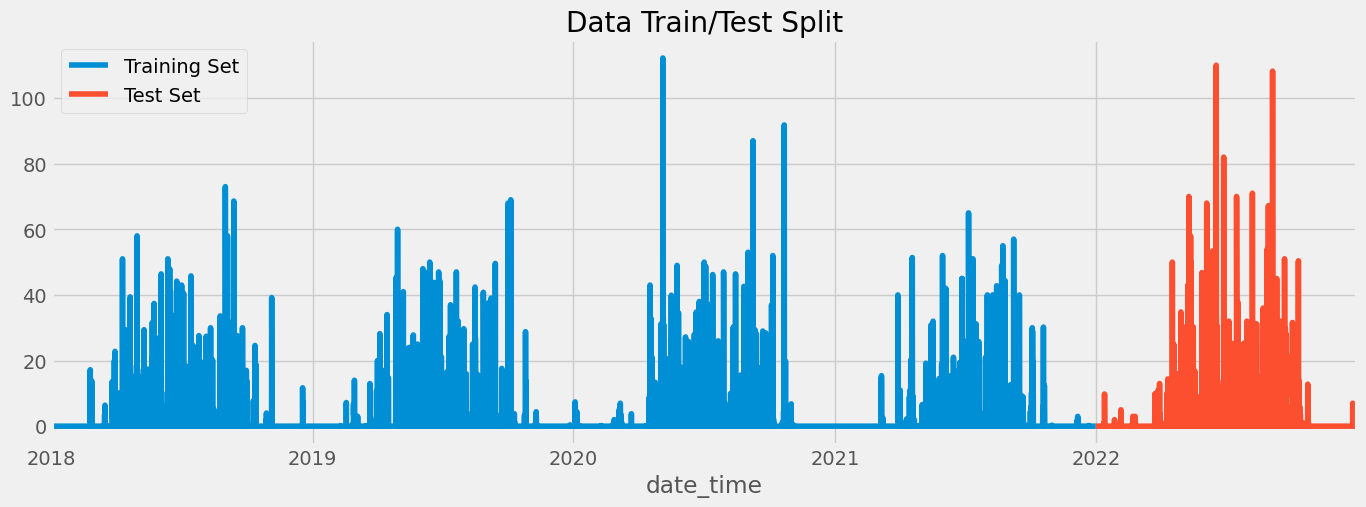

In [ ]:
train = df.iloc[:11687]
test = df.iloc[11687:]

fig, ax = plt.subplots(figsize=(15, 5))
train['rainfall'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['rainfall'].plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

# Simple Prophet Model

In [ ]:
# Format data for prophet model using ds and y
train_prophet = train.reset_index() \
    .rename(columns={'date_time':'ds',
                     'rainfall':'y'})



In [ ]:
%%time
model = Prophet()
model.fit(train_prophet)



DEBUG:cmdstanpy:input tempfile: /tmp/tmphgu1updz/4wvol7pr.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgu1updz/4c3ub2s5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91007', 'data', 'file=/tmp/tmphgu1updz/4wvol7pr.json', 'init=/tmp/tmphgu1updz/4c3ub2s5.json', 'output', 'file=/tmp/tmphgu1updz/prophet_modelw8shi5ds/prophet_model-20230730062632.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:26:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:26:33 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 1.36 s, sys: 88.5 ms, total: 1.44 s
Wall time: 3.25 s


In [ ]:
# Predict on test set with model
test_prophet = test.reset_index() \
    .rename(columns={'date_time':'ds',
                     'rainfall':'y'})

test_fcst = model.predict(test_prophet)

In [ ]:
test_fcst.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-12-31 21:00:00,1.102049,-5.584929,7.710935,1.102049,1.102049,-0.143586,-0.143586,-0.143586,0.781944,...,0.294795,0.294795,0.294795,-1.220325,-1.220325,-1.220325,0.0,0.0,0.0,0.958463
1,2022-01-01 00:00:00,1.102020,-6.434341,7.076876,1.102020,1.102020,-0.262517,-0.262517,-0.262517,0.650522,...,0.307730,0.307730,0.307730,-1.220769,-1.220769,-1.220769,0.0,0.0,0.0,0.839503
2,2022-01-01 03:00:00,1.101991,-6.268786,7.309412,1.101991,1.101991,-0.632969,-0.632969,-0.632969,0.293047,...,0.295196,0.295196,0.295196,-1.221212,-1.221212,-1.221212,0.0,0.0,0.0,0.469021
3,2022-01-01 06:00:00,1.101961,-7.061666,6.878564,1.101961,1.101961,-1.252194,-1.252194,-1.252194,-0.288080,...,0.257543,0.257543,0.257543,-1.221656,-1.221656,-1.221656,0.0,0.0,0.0,-0.150233
4,2022-01-01 09:00:00,1.101932,-7.325250,6.154914,1.101932,1.101932,-1.450560,-1.450560,-1.450560,-0.425641,...,0.197181,0.197181,0.197181,-1.222101,-1.222101,-1.222101,0.0,0.0,0.0,-0.348628


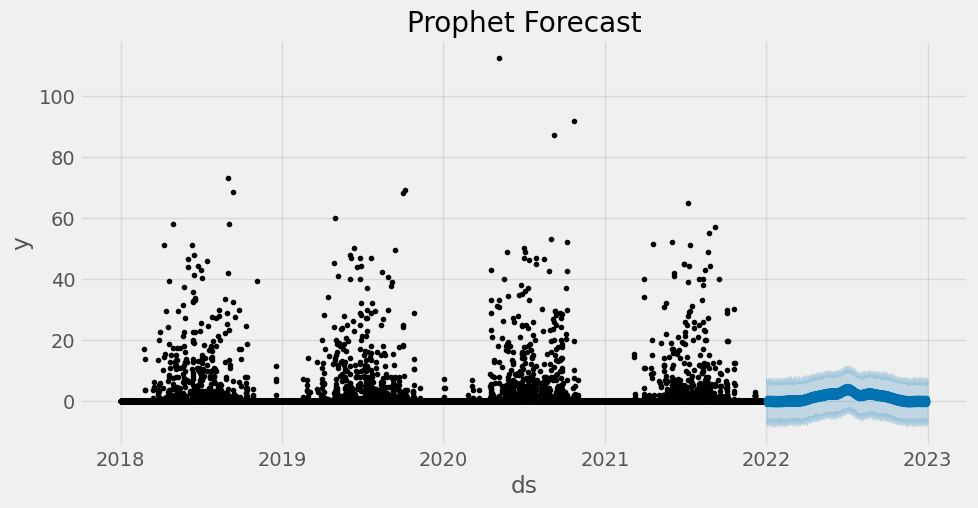

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
fig = model.plot(test_fcst, ax=ax)
ax.set_title('Prophet Forecast')
plt.show()



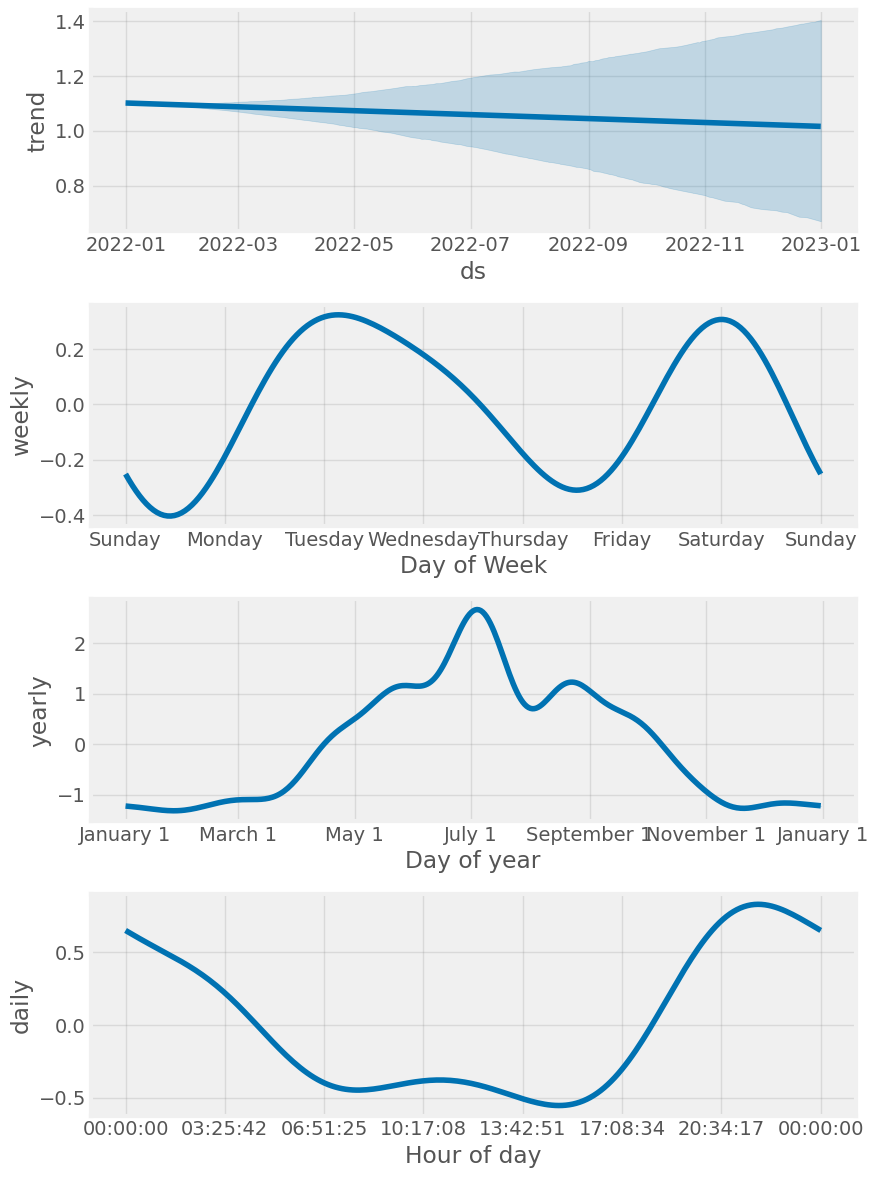

In [ ]:
fig = model.plot_components(test_fcst)
plt.show()

# Compare Forecast to Actuals

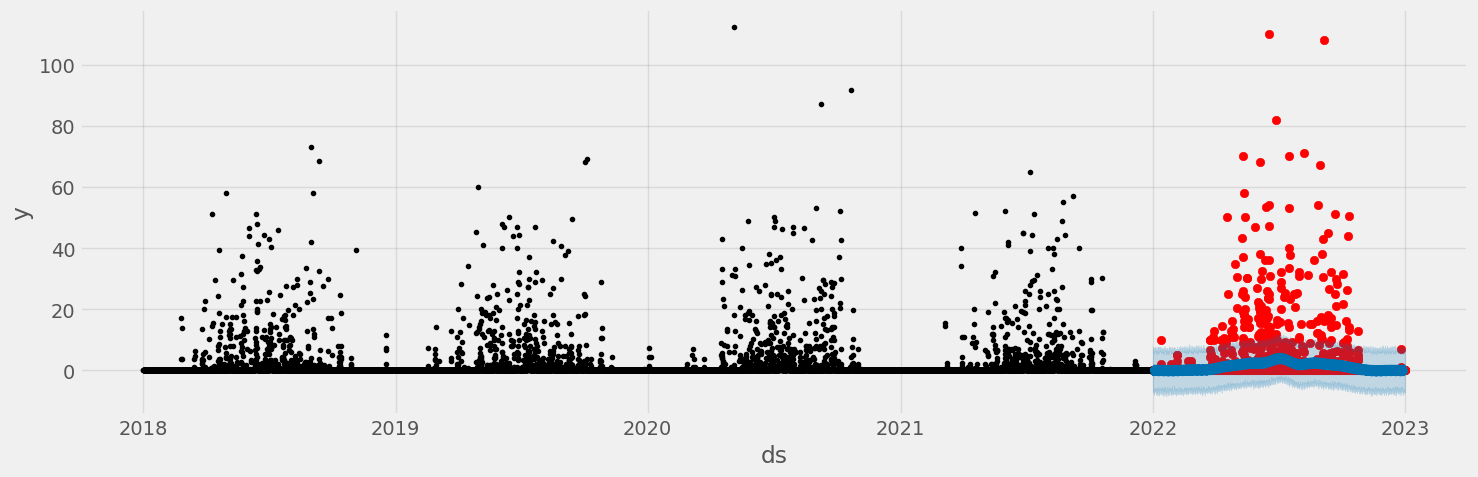

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['rainfall'], color='r')
fig = model.plot(test_fcst, ax=ax)

ConversionError: ignored

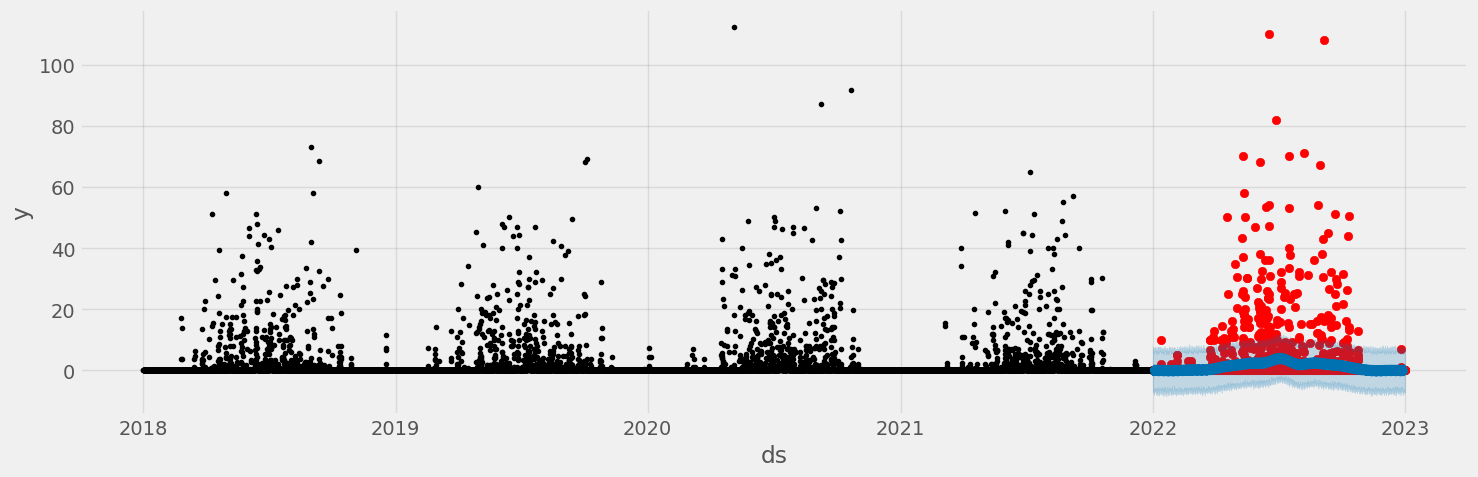

In [ ]:
# Plot the forecast with the actuals
f, ax = plt.subplots(figsize=(15, 5))
ax.scatter(test.index, test['rainfall'], color='r')
fig = model.plot(test_fcst, ax=ax)
ax.set_xbound(lower='01-01-2022 00:00:00', upper='01-08-2022 00:00:00')
ax.set_ylim(0, 60000)
ax.set_title('First Week of January Forecast vs Actuals')
plt.show()


# Evaluate the model with Error Metrics

In [ ]:
np.sqrt(mean_squared_error(y_true=test['rainfall'],
                   y_pred=test_fcst['yhat']))



6.993983475218632

In [ ]:
mean_absolute_error(y_true=test['rainfall'],
                   y_pred=test_fcst['yhat'])

In [ ]:
mean_absolute_percentage_error(y_true=test['rainfall'],
                   y_pred=test_fcst['yhat'])

inf

# Adding Holidays

In [ ]:


from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

cal = calendar()


holidays = cal.holidays(start=df.index.min(),
                        end=df.index.max(),
                        return_name=True)
holiday_df = pd.DataFrame(data=holidays,
                          columns=['holiday'])
holiday_df = holiday_df.reset_index().rename(columns={'index':'ds'})



In [ ]:
%%time
model_with_holidays = Prophet(holidays=holiday_df)
model_with_holidays.fit(train_prophet)

DEBUG:cmdstanpy:input tempfile: /tmp/tmphgu1updz/tsy94fej.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmphgu1updz/pgfbly7a.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=91293', 'data', 'file=/tmp/tmphgu1updz/tsy94fej.json', 'init=/tmp/tmphgu1updz/pgfbly7a.json', 'output', 'file=/tmp/tmphgu1updz/prophet_modelzczzvu_z/prophet_model-20230730064436.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
06:44:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
06:44:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


CPU times: user 1.11 s, sys: 103 ms, total: 1.22 s
Wall time: 3.54 s


In [ ]:


# Predict on training set with model
pjme_test_fcst_with_hols = \
    model_with_holidays.predict(df=test_prophet)



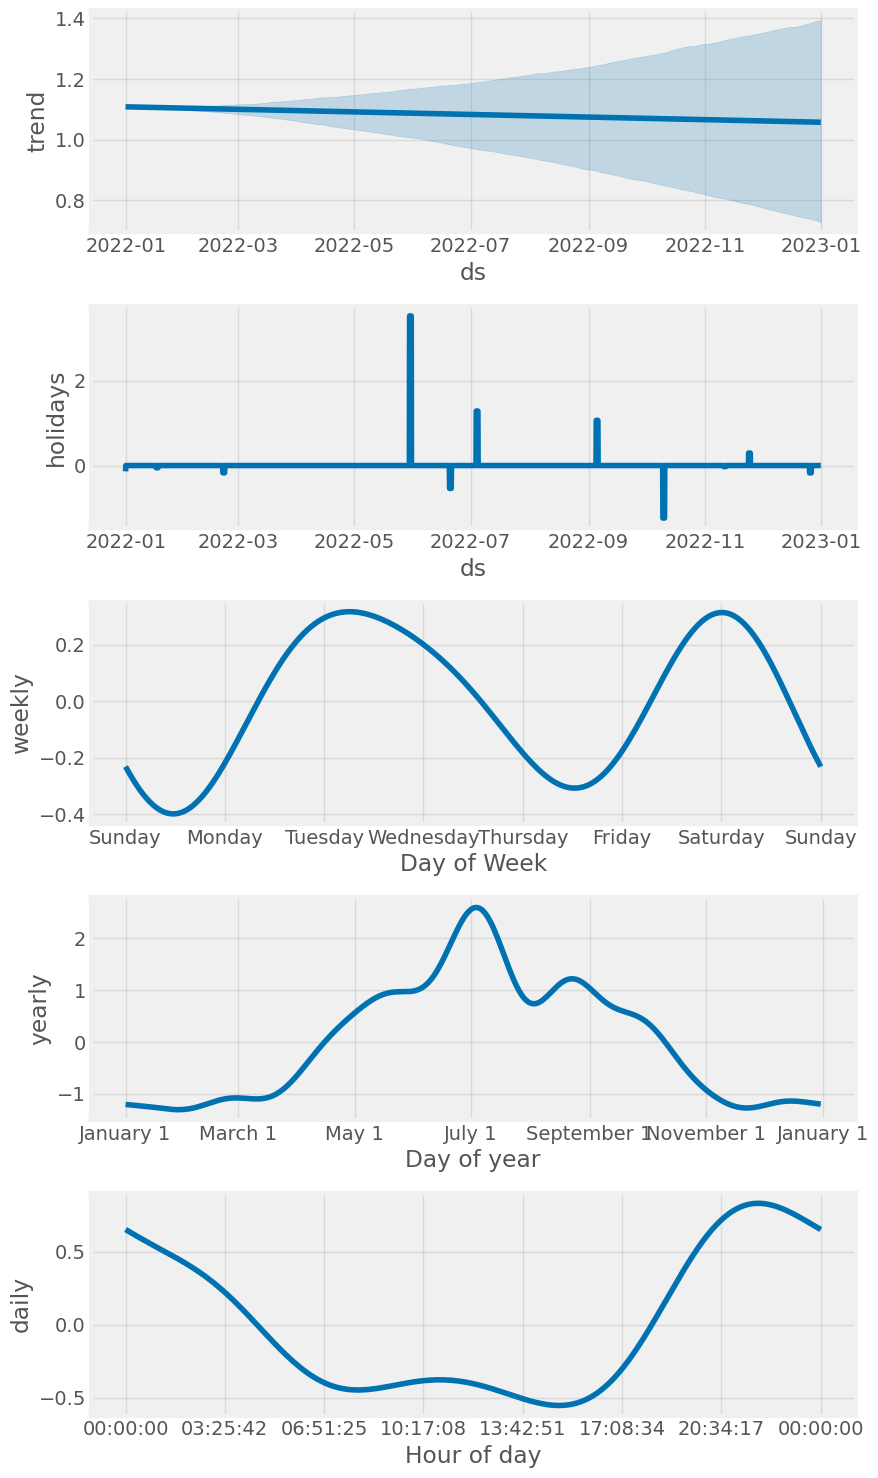

In [ ]:


fig = model_with_holidays.plot_components(
    pjme_test_fcst_with_hols)
plt.show()



In [ ]:
np.sqrt(mean_squared_error(y_true=test['rainfall'],
                   y_pred=pjme_test_fcst_with_hols['yhat']))

6.992736547695849

In [ ]:


mean_absolute_error(y_true=test['rainfall'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])



2.4685099739084926

In [ ]:
mean_absolute_percentage_error(y_true=test['rainfall'],
                   y_pred=pjme_test_fcst_with_hols['yhat'])

inf